# Agent 3: ReAct AI Agent

In [1]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  

from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM

from langchain_groq import ChatGroq
from langchain_core.tools import tool

from langgraph.graph.message import add_messages # Adds reducer functions (to prevent messages overwriting each other)
from langgraph.graph import StateGraph, END

from langgraph.prebuilt import ToolNode

load_dotenv()

True

In [16]:
class AgentState(TypedDict):
    """
    msg: Annotated[Sequence[BaseMessage], add_messages]
    
    Type Breakdown:
    - Sequence[BaseMessage]:
        An ordered collection of BaseMessage objects (e.g., HumanMessage,
        AIMessage, SystemMessage). Represents the conversation history.

    - Annotated[..., add_messages]:
        Adds metadata to the type hint. The `add_messages` function is used
        by the framework (e.g., LangGraph) as a reducer/merge strategy.
        Instead of replacing the message list during updates, new messages
        are appended using the add_messages logic.

    Overall Meaning:
        `msg` stores conversation messages, and updates to this field
        will append messages rather than overwrite them.
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

- @tool is a decorator (from frameworks like LangChain) that converts a normal Python function into an LLM-callable tool by wrapping it with metadata (name, description, argument schema).


In [17]:
# it is very importnt to add a docstring, as the llm understands the function from it

@tool
def add(a: int, b:int): 
    """This is an addition function that adds 2 numbers together"""

    return a + b 

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

In [18]:
# add the tools to a list
tools = [add, subtract, multiply]

In [19]:
model = ChatGroq(model="openai/gpt-oss-120b").bind_tools(tools) #-> bind tools to model!!!!!

In [20]:
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content="You are my AI assistant, please answer my query to the best of your ability."
    )
    
    # send the user's input and the system's prompt
    response = model.invoke( [system_prompt] + state['messages'])
    
    return {
        'messages': [response]
    }

In [21]:
def should_continue(state:AgentState):
    msg = state['messages']
    last_msg = msg[-1]
    
    if not last_msg.tool_calls: # -> a property on an AI message that contains the list of tools the model decided to call.
        return "end"
    else:
        return "continue"

In [22]:
graph = StateGraph(AgentState)
graph.add_node("agent", model_call)


# Create a tools node and add it to the graph
tool_node = ToolNode(tools=tools) # add the tools list to the tools node
graph.add_node("tools", tool_node)

graph.set_entry_point("agent")

# Add the tools conition edge to the graph
graph.add_conditional_edges(
    "agent",
    should_continue,
    {   # edge:node
        'continue':"tools",
        'end':END
    }
)

# add another edge to go back to the agent after finishing using the tool
graph.add_edge('tools', 'agent')

app = graph.compile()

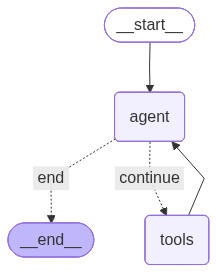

In [23]:
# Visulaize the graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6, then subtract 100. Also tell me a joke please.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6, then subtract 100. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (fc_da8f6c73-2799-46d5-a767-bdcbef31e9b0)
 Call ID: fc_da8f6c73-2799-46d5-a767-bdcbef31e9b0
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_3b4b0249-49ec-4ece-9368-17caef479eb9)
 Call ID: fc_3b4b0249-49ec-4ece-9368-17caef479eb9
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================
Tool Calls:
  subtract (fc_a29df3e4-f803-42b4-ae2f-335d20a4fe95)
 Call ID: fc_a29df3e4-f803-42b4-ae2f-335